In [22]:
import pandas as pd

# Replace the path with your downloaded CSV file
data = pd.read_csv("course_lead_scoring.csv")

# Check the first few rows
data.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [23]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


In [24]:
# Separate categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns
numerical_cols = data.select_dtypes(include=['number']).columns

# Fill missing values
data[categorical_cols] = data[categorical_cols].fillna('NA')
data[numerical_cols] = data[numerical_cols].fillna(0.0)

In [25]:
from sklearn.model_selection import train_test_split

# Define target and features
X = data.drop('converted', axis=1)  # assuming 'converted' is the target column
y = data['converted']

# First, split into train (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

# Then, split temp into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

# Check the shape
print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

Train: (877, 8) Validation: (292, 8) Test: (293, 8)


In [26]:
from sklearn.metrics import roc_auc_score

In [27]:
numerical_features = [
    'lead_score',
    'number_of_courses_viewed',
    'interaction_count',
    'annual_income'
]

In [28]:
auc_scores = {}

for col in numerical_features:
    auc = roc_auc_score(y_train, X_train[col])
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[col])
    auc_scores[col] = auc

# Show results
auc_scores

{'lead_score': 0.6106598956782567,
 'number_of_courses_viewed': 0.7648046448539385,
 'interaction_count': 0.7226651669037616,
 'annual_income': 0.554504251166176}

In [29]:
best_feature = max(auc_scores, key=auc_scores.get)
print("Feature with highest AUC:", best_feature)
print("AUC value:", auc_scores[best_feature])

Feature with highest AUC: number_of_courses_viewed
AUC value: 0.7648046448539385


In [30]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [31]:
# Convert training and validation data to dictionaries
X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')

# Apply one-hot encoding
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(X_train_dict)
X_val_encoded = dv.transform(X_val_dict)

In [32]:
# Initialize and train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [33]:
# Predict probabilities for the positive class
y_val_pred = model.predict_proba(X_val_encoded)[:, 1]

In [34]:
auc_val = roc_auc_score(y_val, y_val_pred)
print("Validation AUC:", round(auc_val, 3))

Validation AUC: 0.866


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

In [36]:
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

In [37]:
for t in thresholds:
    y_pred_threshold = (y_val_pred >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred_threshold))
    recalls.append(recall_score(y_val, y_pred_threshold))

C:\Users\Sumana Sarkar\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sumana Sarkar\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sumana Sarkar\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

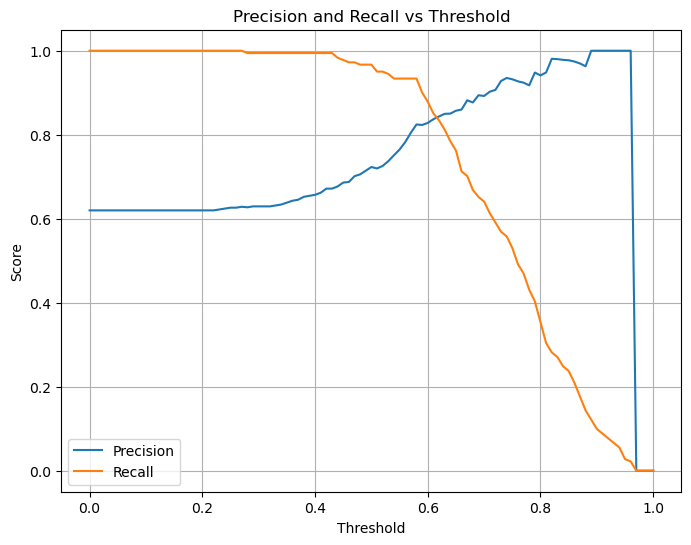

In [38]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Find threshold where precision and recall are closest
diff = np.abs(np.array(precisions) - np.array(recalls))
threshold_intersect = thresholds[np.argmin(diff)]
print("Threshold where precision ≈ recall:", round(threshold_intersect, 3))

Threshold where precision ≈ recall: 0.97


In [40]:
# Compute F1 score from precision and recall
f1_scores = [2 * p * r / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]

In [41]:
max_f1_index = np.argmax(f1_scores)
threshold_max_f1 = thresholds[max_f1_index]
print("Threshold with maximal F1:", round(threshold_max_f1, 2))

Threshold with maximal F1: 0.58


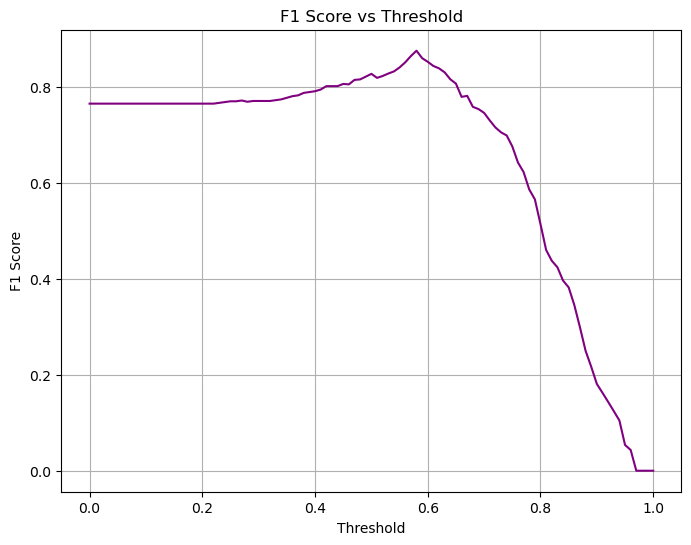

In [42]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.show()

In [43]:
from sklearn.model_selection import KFold

In [45]:
# Combine train + validation
df_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

In [46]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_index, val_index in kf.split(df_full_train):
    X_train_fold = df_full_train.iloc[train_index]
    X_val_fold = df_full_train.iloc[val_index]
    y_train_fold = y_full_train.iloc[train_index]
    y_val_fold = y_full_train.iloc[val_index]
    
    # One-hot encoding
    dv = DictVectorizer(sparse=False)
    X_train_encoded = dv.fit_transform(X_train_fold.to_dict(orient='records'))
    X_val_encoded = dv.transform(X_val_fold.to_dict(orient='records'))
    
    # Train logistic regression
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train_fold)
    
    # Compute AUC
    y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
    auc = roc_auc_score(y_val_fold, y_val_pred)
    auc_scores.append(auc)

# Results
for i, score in enumerate(auc_scores, 1):
    print(f"Fold {i} AUC: {round(score, 3)}")

std_auc = np.std(auc_scores)
print("Standard deviation of AUC across folds:", round(std_auc, 3))

Fold 1 AUC: 0.82
Fold 2 AUC: 0.837
Fold 3 AUC: 0.876
Fold 4 AUC: 0.811
Fold 5 AUC: 0.784
Standard deviation of AUC across folds: 0.031
